# 10章 チューニング技法

In [2]:
# PDF印刷用
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

try:
    from google.colab import files
except:
    pass

pdf_ind = 2
pdf_base = 'pdf-10-'

def create_pdf(plt):
    global pdf_ind, pdf_base
    fn = f'{pdf_base}{pdf_ind:02d}.pdf'
    print(fn)
    plt.savefig(fn)
    try:
        files.download(fn)
    except:
        pass
    pdf_ind = pdf_ind + 1

def graph_pdf(g):
    global pdf_ind, pdf_base
    fnbase = f'{pdf_base}{pdf_ind:02d}'
    fn = f'{pdf_base}{pdf_ind:02d}.pdf'
    print(fnbase)
    g.render(fnbase, view=False)
    try:
        files.download(fn)
    except:
        pass
    pdf_ind = pdf_ind + 1


In [3]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [4]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [5]:
# PyTorch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [33]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [7]:
# GPUチェック

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
# 分類先クラスの名称リスト
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 分類先クラス数　今回は10になる
n_output = len(list(set(classes)))

# 結果確認
print(n_output)

10


## 10.4 過学習とその対応

### ドロップアウト関数の動作確認

In [9]:
# ドロップアウトテスト用ダミーデータの作成

torch.manual_seed(123)
inputs = torch.randn(1, 10)
print(inputs)

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969,  0.2093, -0.9724, -0.7550,
          0.3239, -0.1085]])


In [10]:
# dropout関数の定義
dropout = nn.Dropout(0.5)

# 訓練モードでの挙動
dropout.train()
print(dropout.training)
outputs = dropout(inputs)
print(outputs)

# 予測モードでの挙動
dropout.eval()
print(dropout.training)
outputs = dropout(inputs)
print(outputs)

True
tensor([[-0.0000,  0.2407, -0.0000, -0.4808, -0.0000,  0.0000, -1.9447, -0.0000,
          0.6478, -0.2170]])
False
tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969,  0.2093, -0.9724, -0.7550,
          0.3239, -0.1085]])


## 10.5 共通関数のライブラリ化

In [11]:
# 共通関数のダウンロード
!git clone https://github.com/makaishi2/pythonlibs.git

# 共通関数のロード
from pythonlibs.torch_lib1 import *

# 共通関数の存在チェック
print(README)

Cloning into 'pythonlibs'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 52 (delta 22), reused 40 (delta 13), pack-reused 0
Unpacking objects: 100% (52/52), done.
Common Library for PyTorch
Author: M. Akaishi


In [12]:
# 学習ログ解析

def evaluate_history(history):
    #損失関数値と精度の確認
    print(f'初期状態: 損失関数: {history[0,3]:.5f} 精度: {history[0,4]:.5f}') 
    print(f'最終状態: 損失関数: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失関数)
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失関数値')
    plt.title('学習曲線(損失関数)')
    plt.legend()
    create_pdf(plt)
    plt.show()

    # 学習曲線の表示 (精度)
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    create_pdf(plt)
    plt.show()

In [29]:
# 予測結果表示
def show_predict_result(net, loader, classes, device):

    # DataLoaderから最初の1セットを取得する
    for images, labels in loader:
        break
    n_size = min(len(images), 50)

    # デバイスの割り当て
    inputs = images.to(device)
    labels = labels.to(device)

    # 予測値の計算
    outputs = net(inputs)
    predicted = torch.max(outputs,1)[1]
    images = images.to('cpu')

    # 最初の50個の表示
    plt.figure(figsize=(15, 10))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        image = images[i].numpy()
        label_name = classes[labels[i]]
        predicted_name = classes[predicted[i]]
        img = np.transpose(image, (1, 2, 0))
        img2 = (img + 1)/2 
        plt.imshow(img2)
        if label_name == predicted_name:
            c = 'k'
        else:
            c = 'b'
        ax.set_title(label_name + ':' + predicted_name, c=c)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    create_pdf(plt)
    plt.show()


## データ準備

In [13]:
# transformの定義

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5)
])

In [14]:
# データ取得用関数 DataSet

data_root = './data'

train_set = datasets.CIFAR10(
    root = data_root, train = True, 
    download = True, transform = transform)

# 検証データの取得
test_set = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [15]:
# ミニバッチのサイズ指定
batch_size = 100

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(train_set, 
    batch_size = batch_size, shuffle = True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader = DataLoader(test_set,  
    batch_size = batch_size, shuffle = False) 

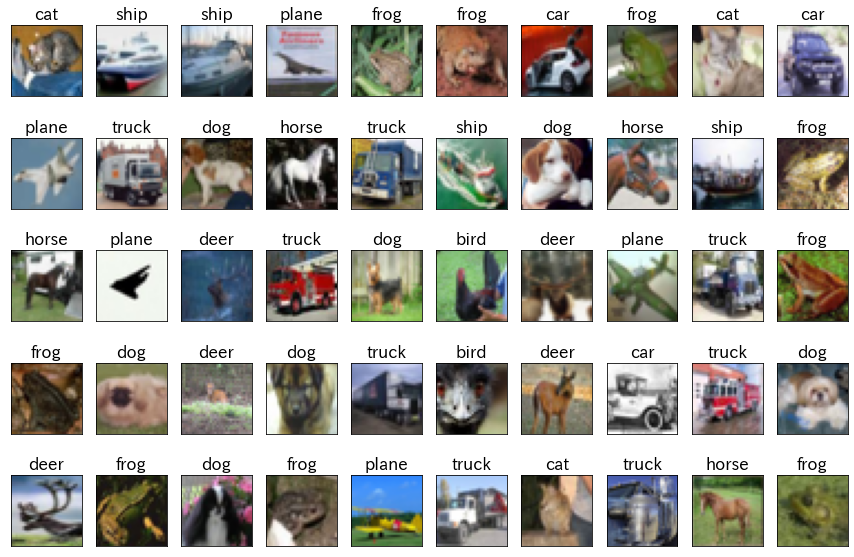

In [16]:
# 最初の50個の表示
for images, labels in test_loader:
    break

plt.figure(figsize=(15, 10))
for i in range(50):
    ax = plt.subplot(5, 10, i + 1)
    image = images[i]
    label = labels[i]
    np_image = image.numpy().copy()
    img = np.transpose(np_image, (1, 2, 0))
    img2 = (img + 1)/2 
    plt.imshow(img2)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 10.6 階層を深くしたモデルの実装

In [17]:
class CNN_v2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.classifier1 = nn.Linear(4*4*128, 128)
        self.classifier2 = nn.Linear(128, 10)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
            )

        self.classifier = nn.Sequential(
            self.classifier1,
            self.relu,
            self.classifier2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

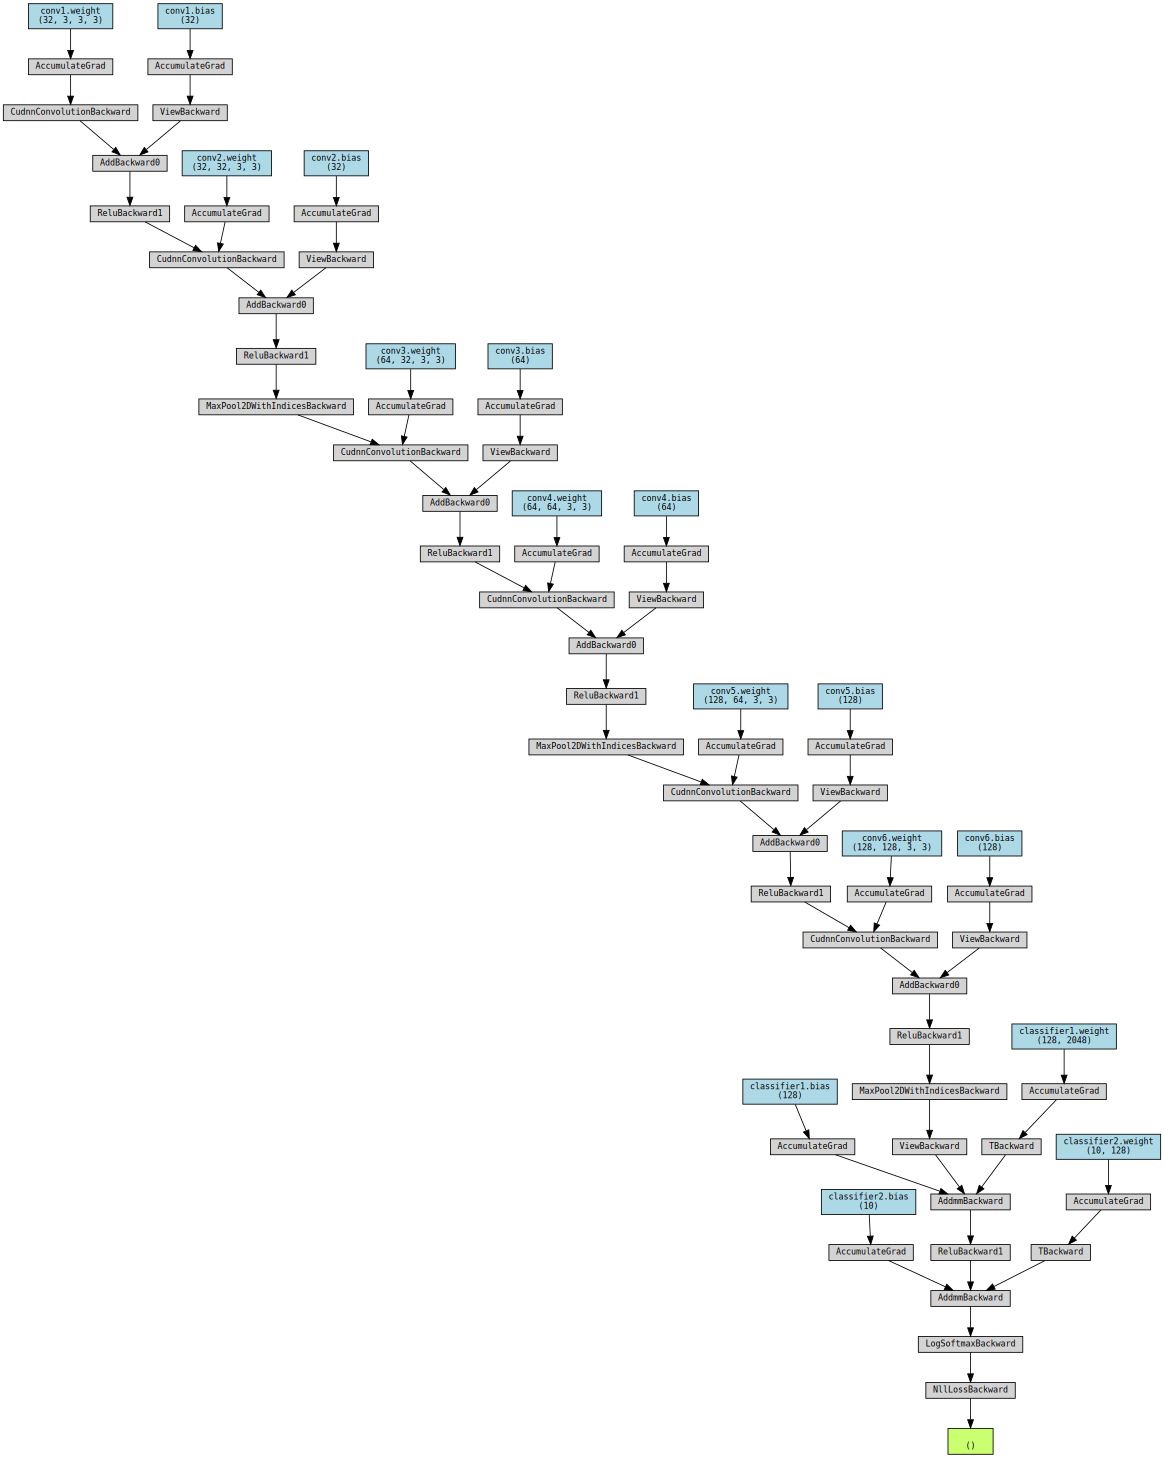

In [18]:
# 損失関数のグラフ表示
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
g = make_dot(loss, params=dict(net.named_parameters()))
g.render('xxx')
display(g)

In [19]:
# 乱数の固定化
torch_seed()

# モデルインスタンスの生成
lr = 0.01
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)
history = np.zeros((0, 5))

In [ ]:
# 学習

num_epochs = 50
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)


Epoch [1/50], loss: 0.02303 acc: 0.10000 val_loss: 0.02303, val_acc: 0.10000



Epoch [2/50], loss: 0.02303 acc: 0.10000 val_loss: 0.02303, val_acc: 0.10000



Epoch [3/50], loss: 0.02302 acc: 0.10144 val_loss: 0.02302, val_acc: 0.10000



Epoch [4/50], loss: 0.02302 acc: 0.10136 val_loss: 0.02302, val_acc: 0.10160



Epoch [5/50], loss: 0.02302 acc: 0.12480 val_loss: 0.02302, val_acc: 0.15770



Epoch [6/50], loss: 0.02301 acc: 0.16052 val_loss: 0.02301, val_acc: 0.19560



Epoch [7/50], loss: 0.02299 acc: 0.19720 val_loss: 0.02295, val_acc: 0.21760



Epoch [8/50], loss: 0.02262 acc: 0.21014 val_loss: 0.02138, val_acc: 0.22080



Epoch [9/50], loss: 0.02033 acc: 0.25870 val_loss: 0.01952, val_acc: 0.29960



Epoch [10/50], loss: 0.01919 acc: 0.30610 val_loss: 0.01853, val_acc: 0.33800



Epoch [11/50], loss: 0.01805 acc: 0.35010 val_loss: 0.01721, val_acc: 0.38310



Epoch [12/50], loss: 0.01710 acc: 0.37892 val_loss: 0.01625, val_acc: 0.40620



Epoch [13/50], loss: 0.01637 acc: 0.40266 val_loss: 0.01572, val_acc: 0.42430



Epoch [14/50], loss: 0.01577 acc: 0.42252 val_loss: 0.01516, val_acc: 0.44660



Epoch [15/50], loss: 0.01532 acc: 0.43940 val_loss: 0.01542, val_acc: 0.43770



Epoch [16/50], loss: 0.01491 acc: 0.45240 val_loss: 0.01610, val_acc: 0.42090



Epoch [17/50], loss: 0.01450 acc: 0.47142 val_loss: 0.01429, val_acc: 0.48140



Epoch [18/50], loss: 0.01406 acc: 0.49046 val_loss: 0.01413, val_acc: 0.49420



Epoch [19/50], loss: 0.01360 acc: 0.50858 val_loss: 0.01317, val_acc: 0.52360



Epoch [20/50], loss: 0.01313 acc: 0.52942 val_loss: 0.01286, val_acc: 0.53050



Epoch [21/50], loss: 0.01264 acc: 0.54838 val_loss: 0.01251, val_acc: 0.55280



Epoch [22/50], loss: 0.01224 acc: 0.56536 val_loss: 0.01302, val_acc: 0.53400



Epoch [23/50], loss: 0.01183 acc: 0.58230 val_loss: 0.01200, val_acc: 0.57790



Epoch [24/50], loss: 0.01143 acc: 0.59658 val_loss: 0.01123, val_acc: 0.60220



Epoch [25/50], loss: 0.01098 acc: 0.61338 val_loss: 0.01131, val_acc: 0.60010



Epoch [26/50], loss: 0.01060 acc: 0.62860 val_loss: 0.01088, val_acc: 0.61560



Epoch [27/50], loss: 0.01023 acc: 0.63770 val_loss: 0.01170, val_acc: 0.58800



Epoch [28/50], loss: 0.00990 acc: 0.65304 val_loss: 0.01036, val_acc: 0.63820



Epoch [29/50], loss: 0.00954 acc: 0.66556 val_loss: 0.01034, val_acc: 0.63830



Epoch [30/50], loss: 0.00917 acc: 0.67966 val_loss: 0.01011, val_acc: 0.64720



Epoch [31/50], loss: 0.00888 acc: 0.69086 val_loss: 0.00977, val_acc: 0.65320



Epoch [32/50], loss: 0.00854 acc: 0.70402 val_loss: 0.00981, val_acc: 0.65760



Epoch [33/50], loss: 0.00824 acc: 0.71148 val_loss: 0.00943, val_acc: 0.67240



Epoch [34/50], loss: 0.00793 acc: 0.72442 val_loss: 0.00954, val_acc: 0.67320



Epoch [35/50], loss: 0.00761 acc: 0.73678 val_loss: 0.00963, val_acc: 0.66640



Epoch [36/50], loss: 0.00735 acc: 0.74308 val_loss: 0.00924, val_acc: 0.68540



Epoch [37/50], loss: 0.00704 acc: 0.75368 val_loss: 0.00921, val_acc: 0.68520



Epoch [38/50], loss: 0.00671 acc: 0.76588 val_loss: 0.00982, val_acc: 0.66930



Epoch [39/50], loss: 0.00643 acc: 0.77592 val_loss: 0.00914, val_acc: 0.69650



Epoch [40/50], loss: 0.00614 acc: 0.78524 val_loss: 0.00962, val_acc: 0.68250



Epoch [41/50], loss: 0.00582 acc: 0.79652 val_loss: 0.00923, val_acc: 0.70210



Epoch [42/50], loss: 0.00555 acc: 0.80634 val_loss: 0.00968, val_acc: 0.68850



Epoch [43/50], loss: 0.00522 acc: 0.81768 val_loss: 0.00949, val_acc: 0.69750



Epoch [44/50], loss: 0.00490 acc: 0.82904 val_loss: 0.00996, val_acc: 0.69030



Epoch [45/50], loss: 0.00463 acc: 0.83830 val_loss: 0.01080, val_acc: 0.67380



Epoch [46/50], loss: 0.00430 acc: 0.85024 val_loss: 0.01047, val_acc: 0.68880



Epoch [47/50], loss: 0.00404 acc: 0.85728 val_loss: 0.01038, val_acc: 0.70030



Epoch [48/50], loss: 0.00368 acc: 0.87016 val_loss: 0.01089, val_acc: 0.69230



Epoch [49/50], loss: 0.00339 acc: 0.88058 val_loss: 0.01143, val_acc: 0.69400



Epoch [50/50], loss: 0.00312 acc: 0.89020 val_loss: 0.01215, val_acc: 0.68310


初期状態: 損失関数: 0.02303 精度: 0.10000
最終状態: 損失関数: 0.01215 精度: 0.68310
pdf-10-05.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

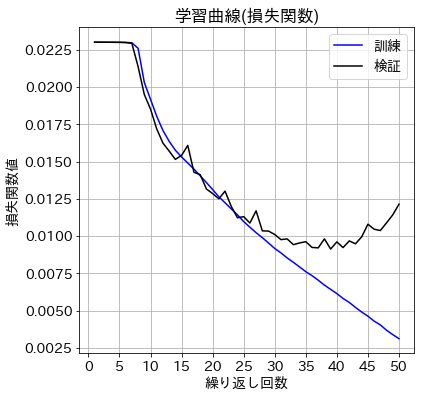

pdf-10-06.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

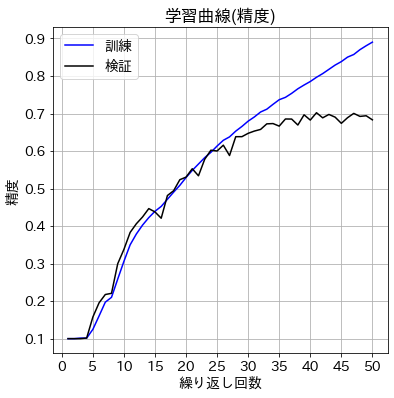

In [ ]:
evaluate_history(history)

## 10.7 最適化関数の選択

### momentumの設定

In [35]:
# 乱数の固定化
torch_seed()

# 最適化関数にmomentumを指定
lr = 0.01
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
history2 = np.zeros((0, 5))

In [36]:
# 学習

num_epochs = 20
history2 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history2)


Epoch [1/20], loss: 0.02283 acc: 0.12388 val_loss: 0.02043, val_acc: 0.26420



Epoch [2/20], loss: 0.01809 acc: 0.33076 val_loss: 0.01550, val_acc: 0.42720



Epoch [3/20], loss: 0.01428 acc: 0.47596 val_loss: 0.01296, val_acc: 0.52230



Epoch [4/20], loss: 0.01182 acc: 0.57686 val_loss: 0.01079, val_acc: 0.60490



Epoch [5/20], loss: 0.00977 acc: 0.65350 val_loss: 0.00946, val_acc: 0.66560



Epoch [6/20], loss: 0.00823 acc: 0.71090 val_loss: 0.00802, val_acc: 0.72030



Epoch [7/20], loss: 0.00687 acc: 0.76022 val_loss: 0.00793, val_acc: 0.72520



Epoch [8/20], loss: 0.00586 acc: 0.79436 val_loss: 0.00744, val_acc: 0.74750



Epoch [9/20], loss: 0.00500 acc: 0.82610 val_loss: 0.00696, val_acc: 0.76520



Epoch [10/20], loss: 0.00423 acc: 0.85132 val_loss: 0.00726, val_acc: 0.76550



Epoch [11/20], loss: 0.00351 acc: 0.87342 val_loss: 0.00797, val_acc: 0.75680



Epoch [12/20], loss: 0.00280 acc: 0.90054 val_loss: 0.00815, val_acc: 0.76120



Epoch [13/20], loss: 0.00230 acc: 0.91844 val_loss: 0.00906, val_acc: 0.76210



Epoch [14/20], loss: 0.00195 acc: 0.93034 val_loss: 0.00939, val_acc: 0.75760



Epoch [15/20], loss: 0.00162 acc: 0.94226 val_loss: 0.00974, val_acc: 0.76890



Epoch [16/20], loss: 0.00144 acc: 0.94912 val_loss: 0.01083, val_acc: 0.76850



Epoch [17/20], loss: 0.00120 acc: 0.95770 val_loss: 0.01215, val_acc: 0.75740



Epoch [18/20], loss: 0.00107 acc: 0.96224 val_loss: 0.01159, val_acc: 0.75740



Epoch [19/20], loss: 0.00100 acc: 0.96432 val_loss: 0.01220, val_acc: 0.76440



Epoch [20/20], loss: 0.00090 acc: 0.96870 val_loss: 0.01375, val_acc: 0.75210


初期状態: 損失関数: 0.02043 精度: 0.26420
最終状態: 損失関数: 0.01375 精度: 0.75210
pdf-10-06.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

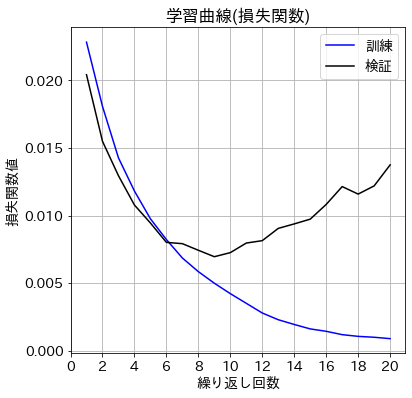

pdf-10-07.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

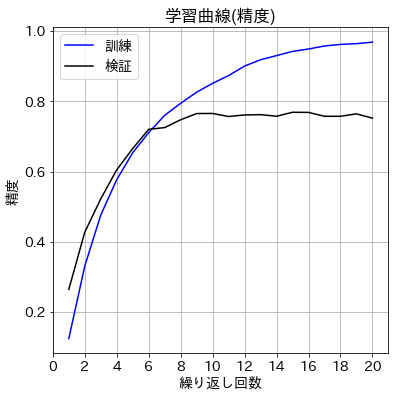

In [37]:
evaluate_history(history2)

### Adamの利用

In [38]:
# 乱数の固定化
torch_seed()

# 最適化関数にAdamを指定
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history3 = np.zeros((0, 5))

In [39]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


In [40]:
# 学習

num_epochs = 20
history3 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history3)


Epoch [1/20], loss: 0.01598 acc: 0.40860 val_loss: 0.01255, val_acc: 0.54560



Epoch [2/20], loss: 0.01118 acc: 0.59976 val_loss: 0.01019, val_acc: 0.63260



Epoch [3/20], loss: 0.00882 acc: 0.68764 val_loss: 0.00950, val_acc: 0.66830



Epoch [4/20], loss: 0.00732 acc: 0.74254 val_loss: 0.00760, val_acc: 0.73740



Epoch [5/20], loss: 0.00609 acc: 0.78412 val_loss: 0.00725, val_acc: 0.74950



Epoch [6/20], loss: 0.00519 acc: 0.81716 val_loss: 0.00694, val_acc: 0.76470



Epoch [7/20], loss: 0.00440 acc: 0.84374 val_loss: 0.00726, val_acc: 0.75930



Epoch [8/20], loss: 0.00367 acc: 0.86828 val_loss: 0.00730, val_acc: 0.76760



Epoch [9/20], loss: 0.00302 acc: 0.89218 val_loss: 0.00798, val_acc: 0.76530



Epoch [10/20], loss: 0.00246 acc: 0.91126 val_loss: 0.00846, val_acc: 0.77090



Epoch [11/20], loss: 0.00203 acc: 0.92914 val_loss: 0.00949, val_acc: 0.76350



Epoch [12/20], loss: 0.00168 acc: 0.93924 val_loss: 0.01024, val_acc: 0.76320



Epoch [13/20], loss: 0.00153 acc: 0.94494 val_loss: 0.01086, val_acc: 0.76210



Epoch [14/20], loss: 0.00131 acc: 0.95352 val_loss: 0.01124, val_acc: 0.76060



Epoch [15/20], loss: 0.00115 acc: 0.95910 val_loss: 0.01152, val_acc: 0.76000



Epoch [16/20], loss: 0.00113 acc: 0.96102 val_loss: 0.01183, val_acc: 0.76550



Epoch [17/20], loss: 0.00100 acc: 0.96536 val_loss: 0.01257, val_acc: 0.76680



Epoch [18/20], loss: 0.00095 acc: 0.96700 val_loss: 0.01330, val_acc: 0.76500



Epoch [19/20], loss: 0.00088 acc: 0.96964 val_loss: 0.01415, val_acc: 0.75100



Epoch [20/20], loss: 0.00087 acc: 0.97002 val_loss: 0.01518, val_acc: 0.75540


初期状態: 損失関数: 0.01255 精度: 0.54560
最終状態: 損失関数: 0.01518 精度: 0.75540
pdf-10-08.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

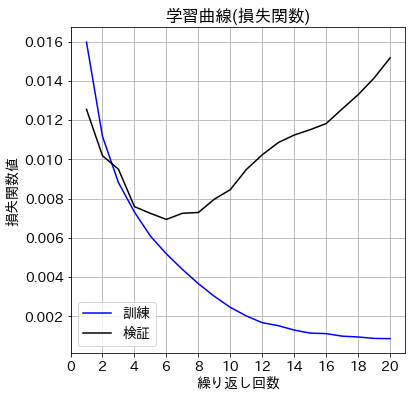

pdf-10-09.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

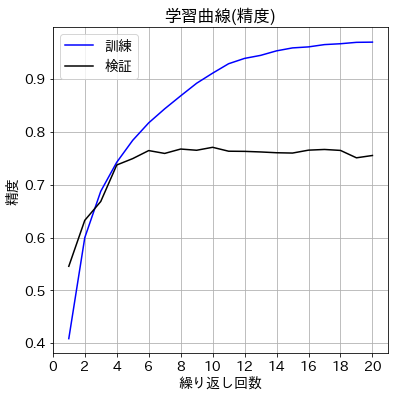

In [41]:
evaluate_history(history3)

### 結果比較

pdf-10-07.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

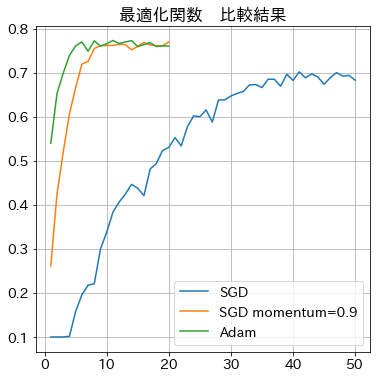

In [ ]:
plt.plot(history[:,0], history[:,4], label='SGD')
plt.plot(history2[:,0], history2[:,4], label='SGD momentum=0.9')
plt.plot(history3[:,0], history3[:,4], label='Adam')
plt.title('最適化関数　比較結果')
plt.legend()
create_pdf(plt)
plt.show()

## 10.8 ドロップアウト

In [20]:
# 予測クラスの定義

class CNN_v3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.classifier1 = nn.Linear(4*4*128, 128)
        self.classifier2 = nn.Linear(128, 10)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.classifier1,
            self.relu,
            self.dropout3,
            self.classifier2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

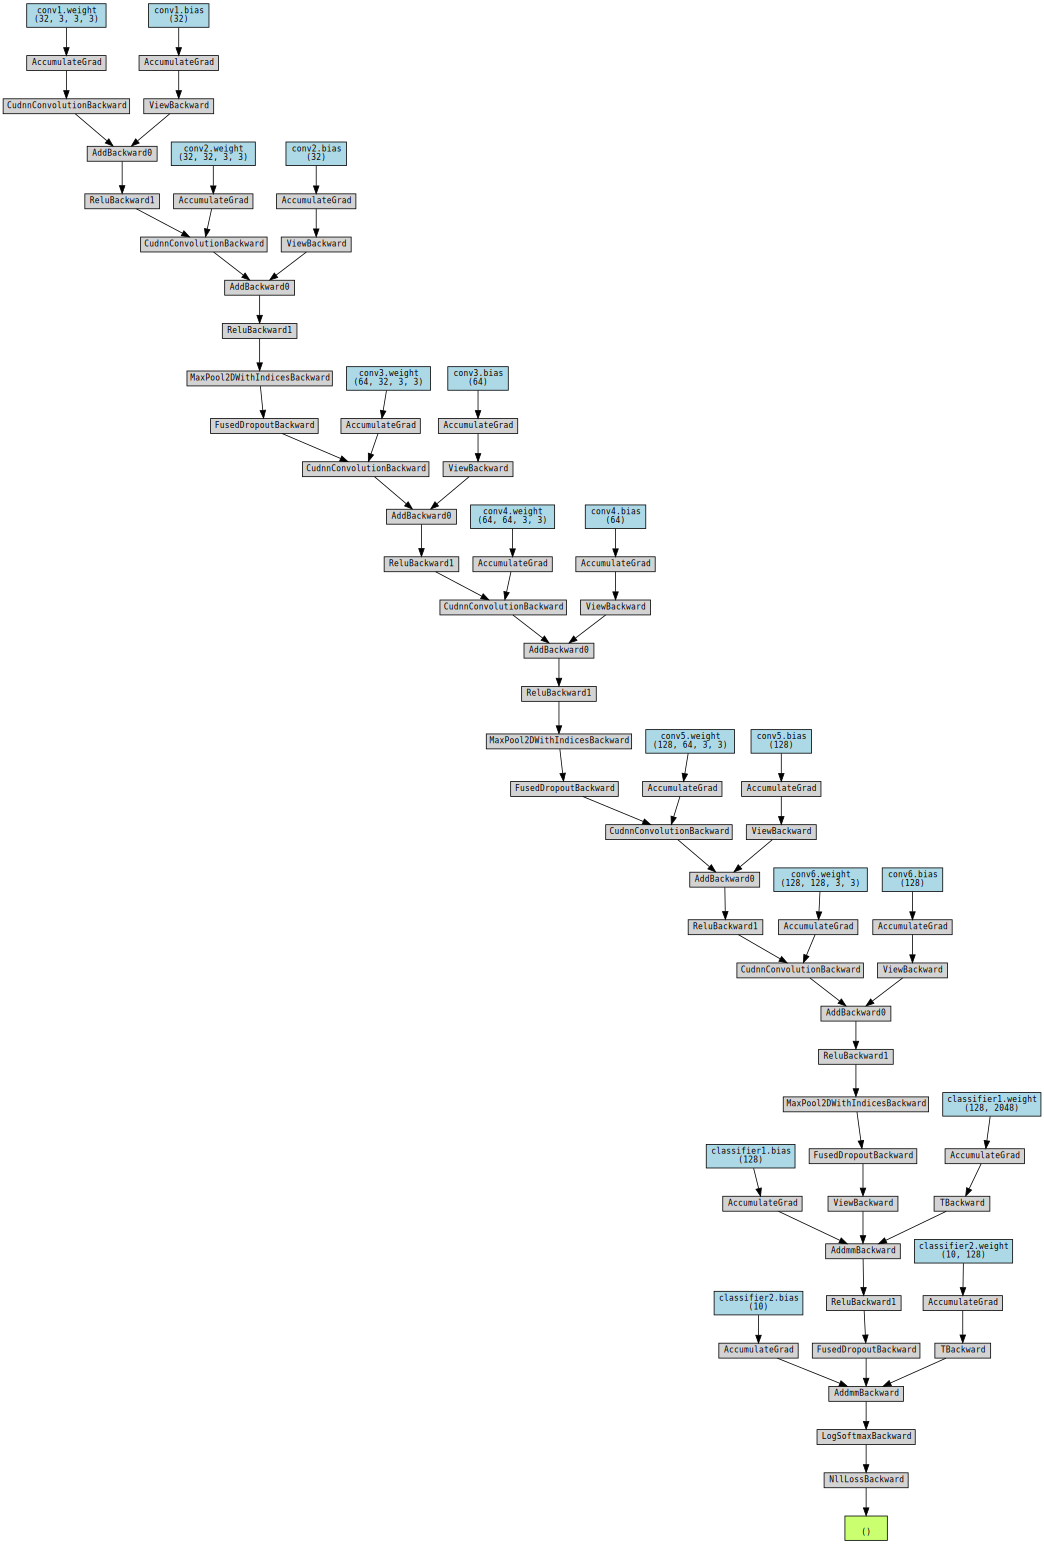

In [22]:
# 損失関数のグラフ表示
net = CNN_v3(n_output).to(device)
criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [25]:
# 乱数の固定化
torch_seed()

# インスタンス生成
net = CNN_v3(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [26]:
# 学習

num_epochs = 50
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)


Epoch [1/50], loss: 0.01749 acc: 0.34196 val_loss: 0.01362, val_acc: 0.49450



Epoch [2/50], loss: 0.01337 acc: 0.51016 val_loss: 0.01123, val_acc: 0.59130



Epoch [3/50], loss: 0.01146 acc: 0.58826 val_loss: 0.00969, val_acc: 0.64930



Epoch [4/50], loss: 0.01023 acc: 0.63838 val_loss: 0.00888, val_acc: 0.68760



Epoch [5/50], loss: 0.00926 acc: 0.67372 val_loss: 0.00799, val_acc: 0.71690



Epoch [6/50], loss: 0.00853 acc: 0.70208 val_loss: 0.00740, val_acc: 0.74070



Epoch [7/50], loss: 0.00793 acc: 0.72290 val_loss: 0.00684, val_acc: 0.75980



Epoch [8/50], loss: 0.00751 acc: 0.74018 val_loss: 0.00693, val_acc: 0.75950



Epoch [9/50], loss: 0.00718 acc: 0.75186 val_loss: 0.00660, val_acc: 0.77350



Epoch [10/50], loss: 0.00684 acc: 0.76322 val_loss: 0.00654, val_acc: 0.77390



Epoch [11/50], loss: 0.00660 acc: 0.76792 val_loss: 0.00611, val_acc: 0.78770



Epoch [12/50], loss: 0.00639 acc: 0.78092 val_loss: 0.00611, val_acc: 0.79080



Epoch [13/50], loss: 0.00616 acc: 0.78600 val_loss: 0.00604, val_acc: 0.79460



Epoch [14/50], loss: 0.00607 acc: 0.79064 val_loss: 0.00627, val_acc: 0.78760



Epoch [15/50], loss: 0.00583 acc: 0.79782 val_loss: 0.00585, val_acc: 0.80260



Epoch [16/50], loss: 0.00573 acc: 0.80186 val_loss: 0.00587, val_acc: 0.79960



Epoch [17/50], loss: 0.00562 acc: 0.80494 val_loss: 0.00585, val_acc: 0.80660



Epoch [18/50], loss: 0.00551 acc: 0.80812 val_loss: 0.00576, val_acc: 0.80850



Epoch [19/50], loss: 0.00544 acc: 0.81080 val_loss: 0.00560, val_acc: 0.81440



Epoch [20/50], loss: 0.00530 acc: 0.81744 val_loss: 0.00575, val_acc: 0.80860



Epoch [21/50], loss: 0.00520 acc: 0.81926 val_loss: 0.00573, val_acc: 0.81290



Epoch [22/50], loss: 0.00509 acc: 0.82466 val_loss: 0.00558, val_acc: 0.81510



Epoch [23/50], loss: 0.00502 acc: 0.82424 val_loss: 0.00572, val_acc: 0.81520



Epoch [24/50], loss: 0.00494 acc: 0.82874 val_loss: 0.00562, val_acc: 0.81640



Epoch [25/50], loss: 0.00485 acc: 0.82990 val_loss: 0.00572, val_acc: 0.81330



Epoch [26/50], loss: 0.00481 acc: 0.83208 val_loss: 0.00542, val_acc: 0.82100



Epoch [27/50], loss: 0.00475 acc: 0.83422 val_loss: 0.00567, val_acc: 0.81450



Epoch [28/50], loss: 0.00468 acc: 0.83766 val_loss: 0.00536, val_acc: 0.82280



Epoch [29/50], loss: 0.00466 acc: 0.83786 val_loss: 0.00556, val_acc: 0.81970



Epoch [30/50], loss: 0.00464 acc: 0.83938 val_loss: 0.00553, val_acc: 0.82240



Epoch [31/50], loss: 0.00460 acc: 0.84148 val_loss: 0.00569, val_acc: 0.81590



Epoch [32/50], loss: 0.00456 acc: 0.83988 val_loss: 0.00533, val_acc: 0.82790



Epoch [33/50], loss: 0.00451 acc: 0.84142 val_loss: 0.00536, val_acc: 0.82630



Epoch [34/50], loss: 0.00441 acc: 0.84776 val_loss: 0.00584, val_acc: 0.81290



Epoch [35/50], loss: 0.00438 acc: 0.84824 val_loss: 0.00564, val_acc: 0.82620



Epoch [36/50], loss: 0.00436 acc: 0.84738 val_loss: 0.00534, val_acc: 0.82580



Epoch [37/50], loss: 0.00432 acc: 0.84946 val_loss: 0.00564, val_acc: 0.82160



Epoch [38/50], loss: 0.00430 acc: 0.84970 val_loss: 0.00546, val_acc: 0.82440



Epoch [39/50], loss: 0.00426 acc: 0.85254 val_loss: 0.00534, val_acc: 0.82870



Epoch [40/50], loss: 0.00420 acc: 0.85392 val_loss: 0.00528, val_acc: 0.83160



Epoch [41/50], loss: 0.00424 acc: 0.85356 val_loss: 0.00581, val_acc: 0.82340



Epoch [42/50], loss: 0.00413 acc: 0.85758 val_loss: 0.00530, val_acc: 0.83300



Epoch [43/50], loss: 0.00407 acc: 0.85994 val_loss: 0.00539, val_acc: 0.82840



Epoch [44/50], loss: 0.00407 acc: 0.85888 val_loss: 0.00549, val_acc: 0.83250



Epoch [45/50], loss: 0.00410 acc: 0.85802 val_loss: 0.00546, val_acc: 0.82800



Epoch [46/50], loss: 0.00404 acc: 0.85896 val_loss: 0.00546, val_acc: 0.82900



Epoch [47/50], loss: 0.00403 acc: 0.85926 val_loss: 0.00532, val_acc: 0.83420



Epoch [48/50], loss: 0.00394 acc: 0.86352 val_loss: 0.00555, val_acc: 0.82580



Epoch [49/50], loss: 0.00393 acc: 0.86458 val_loss: 0.00547, val_acc: 0.82620



Epoch [50/50], loss: 0.00393 acc: 0.86404 val_loss: 0.00519, val_acc: 0.83560


初期状態: 損失関数: 0.01362 精度: 0.49450
最終状態: 損失関数: 0.00519 精度: 0.83560
pdf-10-02.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

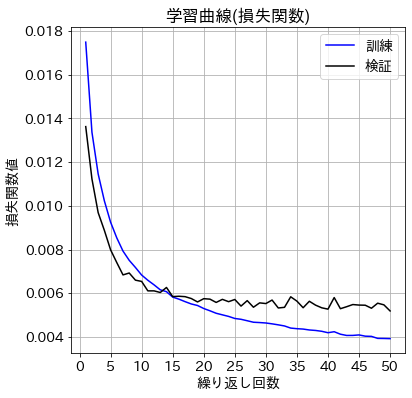

pdf-10-03.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

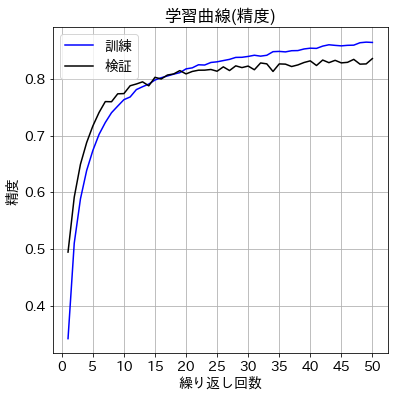

In [27]:
evaluate_history(history)

## 10.9 Batch Normalization

In [24]:
class CNN_v4(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.classifier1 = nn.Linear(4*4*128, 128)
        self.classifier2 = nn.Linear(128, 10)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)

        self.features = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.conv2,
            self.bn2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.bn3,
            self.relu,
            self.conv4,
            self.bn4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.bn5,
            self.relu,
            self.conv6,
            self.bn6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.classifier1,
            self.relu,
            self.dropout3,
            self.classifier2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [31]:
# 乱数の固定化
torch_seed()

# インスタンス生成
net = CNN_v4(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [32]:
# 学習

num_epochs = 50
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)


Epoch [1/50], loss: 0.01499 acc: 0.44604 val_loss: 0.01057, val_acc: 0.61590



Epoch [2/50], loss: 0.01122 acc: 0.60290 val_loss: 0.00977, val_acc: 0.65010



Epoch [3/50], loss: 0.00978 acc: 0.65744 val_loss: 0.00788, val_acc: 0.71800



Epoch [4/50], loss: 0.00892 acc: 0.69058 val_loss: 0.00782, val_acc: 0.72100



Epoch [5/50], loss: 0.00830 acc: 0.71346 val_loss: 0.00685, val_acc: 0.76310



Epoch [6/50], loss: 0.00778 acc: 0.73312 val_loss: 0.00661, val_acc: 0.77130



Epoch [7/50], loss: 0.00742 acc: 0.74736 val_loss: 0.00573, val_acc: 0.80090



Epoch [8/50], loss: 0.00701 acc: 0.76088 val_loss: 0.00599, val_acc: 0.79520



Epoch [9/50], loss: 0.00665 acc: 0.77554 val_loss: 0.00595, val_acc: 0.79570



Epoch [10/50], loss: 0.00638 acc: 0.78650 val_loss: 0.00546, val_acc: 0.81370



Epoch [11/50], loss: 0.00608 acc: 0.79336 val_loss: 0.00533, val_acc: 0.82100



Epoch [12/50], loss: 0.00588 acc: 0.80326 val_loss: 0.00507, val_acc: 0.82850



Epoch [13/50], loss: 0.00558 acc: 0.81212 val_loss: 0.00499, val_acc: 0.83370



Epoch [14/50], loss: 0.00543 acc: 0.81842 val_loss: 0.00502, val_acc: 0.83310



Epoch [15/50], loss: 0.00527 acc: 0.82494 val_loss: 0.00543, val_acc: 0.82240



Epoch [16/50], loss: 0.00512 acc: 0.82924 val_loss: 0.00486, val_acc: 0.83780



Epoch [17/50], loss: 0.00494 acc: 0.83564 val_loss: 0.00477, val_acc: 0.84030



Epoch [18/50], loss: 0.00475 acc: 0.84142 val_loss: 0.00486, val_acc: 0.83940



Epoch [19/50], loss: 0.00459 acc: 0.84640 val_loss: 0.00464, val_acc: 0.85130



Epoch [20/50], loss: 0.00446 acc: 0.85148 val_loss: 0.00482, val_acc: 0.84220



Epoch [21/50], loss: 0.00440 acc: 0.85148 val_loss: 0.00461, val_acc: 0.84960



Epoch [22/50], loss: 0.00429 acc: 0.85428 val_loss: 0.00467, val_acc: 0.84830



Epoch [23/50], loss: 0.00417 acc: 0.86150 val_loss: 0.00478, val_acc: 0.84920



Epoch [24/50], loss: 0.00409 acc: 0.86162 val_loss: 0.00465, val_acc: 0.85070



Epoch [25/50], loss: 0.00398 acc: 0.86590 val_loss: 0.00453, val_acc: 0.85560



Epoch [26/50], loss: 0.00393 acc: 0.86914 val_loss: 0.00442, val_acc: 0.86000



Epoch [27/50], loss: 0.00385 acc: 0.87046 val_loss: 0.00476, val_acc: 0.85210



Epoch [28/50], loss: 0.00371 acc: 0.87604 val_loss: 0.00471, val_acc: 0.84860



Epoch [29/50], loss: 0.00366 acc: 0.87986 val_loss: 0.00458, val_acc: 0.85880



Epoch [30/50], loss: 0.00355 acc: 0.88110 val_loss: 0.00468, val_acc: 0.85870



Epoch [31/50], loss: 0.00350 acc: 0.88308 val_loss: 0.00437, val_acc: 0.85980



Epoch [32/50], loss: 0.00336 acc: 0.88626 val_loss: 0.00437, val_acc: 0.86220



Epoch [33/50], loss: 0.00339 acc: 0.88648 val_loss: 0.00445, val_acc: 0.86000



Epoch [34/50], loss: 0.00327 acc: 0.89018 val_loss: 0.00434, val_acc: 0.86130



Epoch [35/50], loss: 0.00323 acc: 0.88964 val_loss: 0.00464, val_acc: 0.85520



Epoch [36/50], loss: 0.00319 acc: 0.89268 val_loss: 0.00441, val_acc: 0.86320



Epoch [37/50], loss: 0.00313 acc: 0.89412 val_loss: 0.00480, val_acc: 0.85780



Epoch [38/50], loss: 0.00310 acc: 0.89430 val_loss: 0.00431, val_acc: 0.86810



Epoch [39/50], loss: 0.00304 acc: 0.89842 val_loss: 0.00428, val_acc: 0.86720



Epoch [40/50], loss: 0.00298 acc: 0.90032 val_loss: 0.00451, val_acc: 0.86570



Epoch [41/50], loss: 0.00292 acc: 0.90192 val_loss: 0.00447, val_acc: 0.86230



Epoch [42/50], loss: 0.00295 acc: 0.90118 val_loss: 0.00450, val_acc: 0.86830



Epoch [43/50], loss: 0.00286 acc: 0.90422 val_loss: 0.00444, val_acc: 0.86700



Epoch [44/50], loss: 0.00280 acc: 0.90532 val_loss: 0.00444, val_acc: 0.87010



Epoch [45/50], loss: 0.00276 acc: 0.90750 val_loss: 0.00439, val_acc: 0.86880



Epoch [46/50], loss: 0.00271 acc: 0.90830 val_loss: 0.00447, val_acc: 0.87080



Epoch [47/50], loss: 0.00271 acc: 0.90636 val_loss: 0.00473, val_acc: 0.86510



Epoch [48/50], loss: 0.00260 acc: 0.91204 val_loss: 0.00439, val_acc: 0.86820



Epoch [49/50], loss: 0.00262 acc: 0.91086 val_loss: 0.00437, val_acc: 0.87410



Epoch [50/50], loss: 0.00258 acc: 0.91244 val_loss: 0.00452, val_acc: 0.86640


初期状態: 損失関数: 0.01057 精度: 0.61590
最終状態: 損失関数: 0.00452 精度: 0.86640
pdf-10-04.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

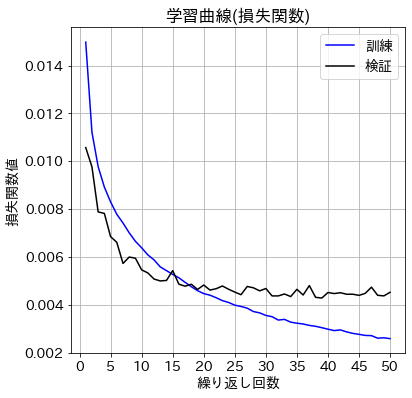

pdf-10-05.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

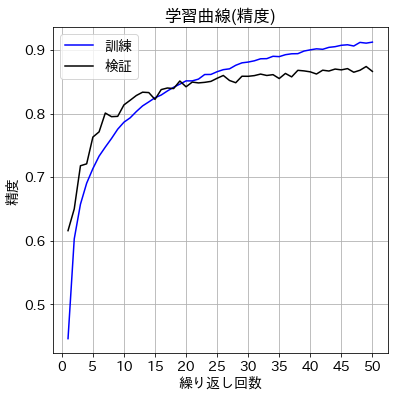

In [33]:
evaluate_history(history)

## 10.10 Data Augumentation

In [17]:
# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
transform_train = transforms.Compose([
  transforms.RandomHorizontalFlip(p=0.5), 
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5), 
  transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

In [18]:
# transfrom_trainを利用したDataSetの定義
train_set2 = datasets.CIFAR10(
    root = data_root, train = True, 
    download = True, transform = transform_train)

# traisform_trainを利用したLadaLoaderの定義
batch_size = 100
train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


pdf-10-02.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

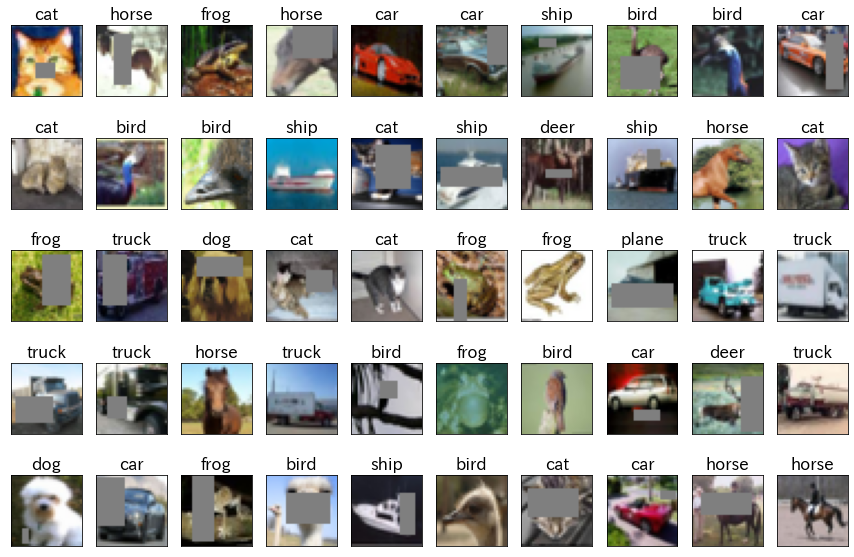

In [22]:
# 新しい訓練用データの先頭50個を表示してみる

# 乱数初期化
torch_seed()

for images, labels in train_loader2:
    break
    
plt.figure(figsize=(15, 10))
for i in range(50):
    ax = plt.subplot(5, 10, i + 1)
    image = images[i]
    label = labels[i]
    np_image = image.numpy().copy()
    img = np.transpose(np_image, (1, 2, 0))
    img2 = (img + 1)/2 
    plt.imshow(img2)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
create_pdf(plt)
plt.show()

In [25]:
# 乱数の固定化
torch_seed()

# インスタンス生成
net = CNN_v4(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [26]:
# 学習
# 同じモデルでtrain_loader2に変更

num_epochs = 100
history = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader, device, history)


Epoch [1/100], loss: 0.01618 acc: 0.39874 val_loss: 0.01227, val_acc: 0.55220



Epoch [2/100], loss: 0.01284 acc: 0.53658 val_loss: 0.01141, val_acc: 0.59310



Epoch [3/100], loss: 0.01155 acc: 0.59042 val_loss: 0.00958, val_acc: 0.65510



Epoch [4/100], loss: 0.01066 acc: 0.62520 val_loss: 0.00837, val_acc: 0.70250



Epoch [5/100], loss: 0.01011 acc: 0.64402 val_loss: 0.00794, val_acc: 0.72100



Epoch [6/100], loss: 0.00958 acc: 0.66500 val_loss: 0.00759, val_acc: 0.73550



Epoch [7/100], loss: 0.00931 acc: 0.67832 val_loss: 0.00746, val_acc: 0.73680



Epoch [8/100], loss: 0.00896 acc: 0.69134 val_loss: 0.00729, val_acc: 0.74420



Epoch [9/100], loss: 0.00864 acc: 0.70070 val_loss: 0.00641, val_acc: 0.77650



Epoch [10/100], loss: 0.00848 acc: 0.70994 val_loss: 0.00711, val_acc: 0.75660



Epoch [11/100], loss: 0.00817 acc: 0.72022 val_loss: 0.00643, val_acc: 0.78020



Epoch [12/100], loss: 0.00796 acc: 0.72844 val_loss: 0.00583, val_acc: 0.79770



Epoch [13/100], loss: 0.00771 acc: 0.73588 val_loss: 0.00613, val_acc: 0.79020



Epoch [14/100], loss: 0.00756 acc: 0.74138 val_loss: 0.00600, val_acc: 0.79590



Epoch [15/100], loss: 0.00738 acc: 0.74966 val_loss: 0.00628, val_acc: 0.79040



Epoch [16/100], loss: 0.00723 acc: 0.75502 val_loss: 0.00562, val_acc: 0.80890



Epoch [17/100], loss: 0.00707 acc: 0.76264 val_loss: 0.00523, val_acc: 0.81890



Epoch [18/100], loss: 0.00698 acc: 0.76624 val_loss: 0.00538, val_acc: 0.81510



Epoch [19/100], loss: 0.00679 acc: 0.77180 val_loss: 0.00523, val_acc: 0.82420



Epoch [20/100], loss: 0.00669 acc: 0.77576 val_loss: 0.00516, val_acc: 0.82540



Epoch [21/100], loss: 0.00659 acc: 0.78060 val_loss: 0.00527, val_acc: 0.82520



Epoch [22/100], loss: 0.00640 acc: 0.78574 val_loss: 0.00536, val_acc: 0.82180



Epoch [23/100], loss: 0.00640 acc: 0.78498 val_loss: 0.00456, val_acc: 0.84270



Epoch [24/100], loss: 0.00625 acc: 0.79206 val_loss: 0.00480, val_acc: 0.83820



Epoch [25/100], loss: 0.00619 acc: 0.79192 val_loss: 0.00471, val_acc: 0.84210



Epoch [26/100], loss: 0.00605 acc: 0.79728 val_loss: 0.00448, val_acc: 0.85040



Epoch [27/100], loss: 0.00601 acc: 0.79936 val_loss: 0.00471, val_acc: 0.84310



Epoch [28/100], loss: 0.00594 acc: 0.80106 val_loss: 0.00449, val_acc: 0.84910



Epoch [29/100], loss: 0.00581 acc: 0.80532 val_loss: 0.00455, val_acc: 0.84650



Epoch [30/100], loss: 0.00573 acc: 0.80692 val_loss: 0.00435, val_acc: 0.85690



Epoch [31/100], loss: 0.00572 acc: 0.80662 val_loss: 0.00472, val_acc: 0.84560



Epoch [32/100], loss: 0.00563 acc: 0.80912 val_loss: 0.00472, val_acc: 0.84540



Epoch [33/100], loss: 0.00559 acc: 0.81252 val_loss: 0.00431, val_acc: 0.85560



Epoch [34/100], loss: 0.00550 acc: 0.81556 val_loss: 0.00429, val_acc: 0.85970



Epoch [35/100], loss: 0.00546 acc: 0.81736 val_loss: 0.00415, val_acc: 0.85870



Epoch [36/100], loss: 0.00538 acc: 0.81956 val_loss: 0.00412, val_acc: 0.86320



Epoch [37/100], loss: 0.00538 acc: 0.81836 val_loss: 0.00423, val_acc: 0.86050



Epoch [38/100], loss: 0.00525 acc: 0.82360 val_loss: 0.00420, val_acc: 0.86210



Epoch [39/100], loss: 0.00523 acc: 0.82412 val_loss: 0.00414, val_acc: 0.86610



Epoch [40/100], loss: 0.00523 acc: 0.82252 val_loss: 0.00428, val_acc: 0.86030



Epoch [41/100], loss: 0.00521 acc: 0.82296 val_loss: 0.00402, val_acc: 0.86550



Epoch [42/100], loss: 0.00511 acc: 0.82664 val_loss: 0.00405, val_acc: 0.86620



Epoch [43/100], loss: 0.00510 acc: 0.82860 val_loss: 0.00411, val_acc: 0.86410



Epoch [44/100], loss: 0.00502 acc: 0.83136 val_loss: 0.00398, val_acc: 0.86920



Epoch [45/100], loss: 0.00503 acc: 0.83062 val_loss: 0.00409, val_acc: 0.86700



Epoch [46/100], loss: 0.00499 acc: 0.83180 val_loss: 0.00390, val_acc: 0.87620



Epoch [47/100], loss: 0.00488 acc: 0.83518 val_loss: 0.00408, val_acc: 0.86740



Epoch [48/100], loss: 0.00493 acc: 0.83418 val_loss: 0.00390, val_acc: 0.87260



Epoch [49/100], loss: 0.00486 acc: 0.83658 val_loss: 0.00398, val_acc: 0.87160



Epoch [50/100], loss: 0.00485 acc: 0.83514 val_loss: 0.00396, val_acc: 0.87290



Epoch [51/100], loss: 0.00483 acc: 0.83748 val_loss: 0.00392, val_acc: 0.87160



Epoch [52/100], loss: 0.00475 acc: 0.83930 val_loss: 0.00382, val_acc: 0.87250



Epoch [53/100], loss: 0.00476 acc: 0.84090 val_loss: 0.00370, val_acc: 0.87940



Epoch [54/100], loss: 0.00473 acc: 0.83968 val_loss: 0.00368, val_acc: 0.87670



Epoch [55/100], loss: 0.00467 acc: 0.84156 val_loss: 0.00382, val_acc: 0.87530



Epoch [56/100], loss: 0.00467 acc: 0.84308 val_loss: 0.00389, val_acc: 0.87550



Epoch [57/100], loss: 0.00465 acc: 0.84138 val_loss: 0.00386, val_acc: 0.87370



Epoch [58/100], loss: 0.00460 acc: 0.84542 val_loss: 0.00376, val_acc: 0.87820



Epoch [59/100], loss: 0.00457 acc: 0.84498 val_loss: 0.00372, val_acc: 0.87890



Epoch [60/100], loss: 0.00455 acc: 0.84654 val_loss: 0.00377, val_acc: 0.87660



Epoch [61/100], loss: 0.00451 acc: 0.84562 val_loss: 0.00387, val_acc: 0.87510



Epoch [62/100], loss: 0.00452 acc: 0.84776 val_loss: 0.00380, val_acc: 0.87790



Epoch [63/100], loss: 0.00449 acc: 0.84842 val_loss: 0.00385, val_acc: 0.87370



Epoch [64/100], loss: 0.00444 acc: 0.84900 val_loss: 0.00377, val_acc: 0.87820



Epoch [65/100], loss: 0.00446 acc: 0.84790 val_loss: 0.00397, val_acc: 0.87200



Epoch [66/100], loss: 0.00444 acc: 0.84774 val_loss: 0.00368, val_acc: 0.87760



Epoch [67/100], loss: 0.00442 acc: 0.85116 val_loss: 0.00386, val_acc: 0.87590



Epoch [68/100], loss: 0.00443 acc: 0.85056 val_loss: 0.00378, val_acc: 0.87870



Epoch [69/100], loss: 0.00436 acc: 0.85226 val_loss: 0.00355, val_acc: 0.88260



Epoch [70/100], loss: 0.00441 acc: 0.85184 val_loss: 0.00358, val_acc: 0.88160



Epoch [71/100], loss: 0.00434 acc: 0.85216 val_loss: 0.00357, val_acc: 0.88490



Epoch [72/100], loss: 0.00436 acc: 0.85210 val_loss: 0.00355, val_acc: 0.88240



Epoch [73/100], loss: 0.00428 acc: 0.85456 val_loss: 0.00353, val_acc: 0.88220



Epoch [74/100], loss: 0.00428 acc: 0.85470 val_loss: 0.00353, val_acc: 0.88810



Epoch [75/100], loss: 0.00424 acc: 0.85558 val_loss: 0.00364, val_acc: 0.88370



Epoch [76/100], loss: 0.00424 acc: 0.85532 val_loss: 0.00353, val_acc: 0.88370



Epoch [77/100], loss: 0.00427 acc: 0.85392 val_loss: 0.00370, val_acc: 0.88270



Epoch [78/100], loss: 0.00422 acc: 0.85738 val_loss: 0.00344, val_acc: 0.88720



Epoch [79/100], loss: 0.00424 acc: 0.85796 val_loss: 0.00357, val_acc: 0.88540



Epoch [80/100], loss: 0.00418 acc: 0.85652 val_loss: 0.00350, val_acc: 0.88630



Epoch [81/100], loss: 0.00414 acc: 0.85894 val_loss: 0.00359, val_acc: 0.88600



Epoch [82/100], loss: 0.00418 acc: 0.85634 val_loss: 0.00360, val_acc: 0.88580



Epoch [83/100], loss: 0.00416 acc: 0.85780 val_loss: 0.00347, val_acc: 0.88740



Epoch [84/100], loss: 0.00414 acc: 0.85864 val_loss: 0.00351, val_acc: 0.88510



Epoch [85/100], loss: 0.00412 acc: 0.85934 val_loss: 0.00361, val_acc: 0.88440



Epoch [86/100], loss: 0.00409 acc: 0.86012 val_loss: 0.00345, val_acc: 0.88730



Epoch [87/100], loss: 0.00409 acc: 0.86034 val_loss: 0.00349, val_acc: 0.88690



Epoch [88/100], loss: 0.00406 acc: 0.85976 val_loss: 0.00335, val_acc: 0.89250



Epoch [89/100], loss: 0.00411 acc: 0.85938 val_loss: 0.00350, val_acc: 0.89010



Epoch [90/100], loss: 0.00408 acc: 0.86154 val_loss: 0.00338, val_acc: 0.89110



Epoch [91/100], loss: 0.00402 acc: 0.86398 val_loss: 0.00350, val_acc: 0.88620



Epoch [92/100], loss: 0.00400 acc: 0.86396 val_loss: 0.00348, val_acc: 0.88530



Epoch [93/100], loss: 0.00401 acc: 0.86368 val_loss: 0.00330, val_acc: 0.89390



Epoch [94/100], loss: 0.00393 acc: 0.86632 val_loss: 0.00340, val_acc: 0.89320



Epoch [95/100], loss: 0.00401 acc: 0.86282 val_loss: 0.00335, val_acc: 0.88980



Epoch [96/100], loss: 0.00400 acc: 0.86480 val_loss: 0.00344, val_acc: 0.89110



Epoch [97/100], loss: 0.00392 acc: 0.86650 val_loss: 0.00355, val_acc: 0.89010



Epoch [98/100], loss: 0.00397 acc: 0.86426 val_loss: 0.00331, val_acc: 0.89760



Epoch [99/100], loss: 0.00395 acc: 0.86454 val_loss: 0.00341, val_acc: 0.89090



Epoch [100/100], loss: 0.00393 acc: 0.86452 val_loss: 0.00353, val_acc: 0.88650


初期状態: 損失関数: 0.01227 精度: 0.55220
最終状態: 損失関数: 0.00353 精度: 0.88650
pdf-10-03.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

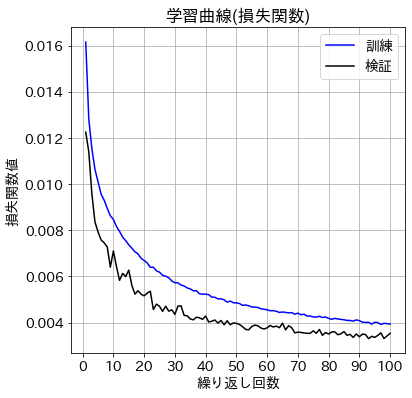

pdf-10-04.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

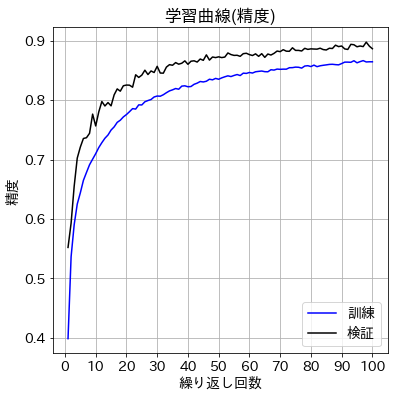

In [27]:
evaluate_history(history)

pdf-10-05.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

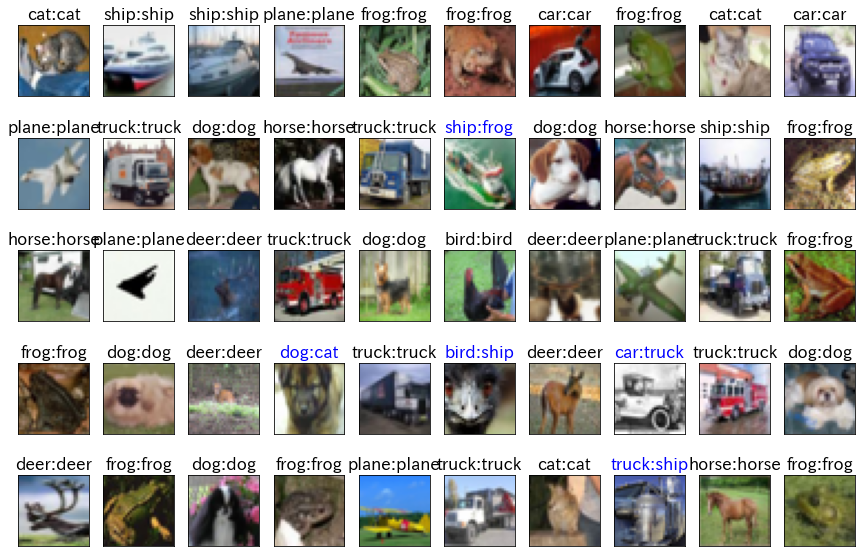

In [30]:
show_predict_result(net, test_loader, classes, device)

pdf-10-08.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

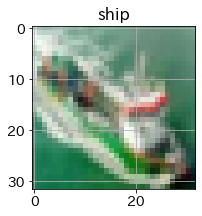

In [66]:
# 間違えた16番目のデータを抽出
for images, lavels in test_loader:
    break
image = images[15]
label = labels[15]

# イメージを表示して確認
plt.figure(figsize=(3,3))
w = image.numpy().copy()
w2 = np.transpose(w, (1, 2, 0))
w3 = (w2 + 1)/2 
plt.title(classes[label])
plt.imshow(w3)
create_pdf(plt)
plt.show()


In [63]:
# 予測値を取得
image = image.view(1, 3, 32, 32)
image = image.to(device)
output = net(image)

# ラベル別の確率値を表示
probs = torch.softmax(output, dim=1)
probs_np = probs.data.to('cpu').numpy()[0]
values = np.frompyfunc(lambda x: f'{x:.04f}', 1, 1)(probs_np)
names = np.array(classes)
tbl = np.array([names, values]).T
print(tbl)

[['plane' '0.0006']
 ['car' '0.0000']
 ['bird' '0.0000']
 ['cat' '0.0000']
 ['deer' '0.0000']
 ['dog' '0.0000']
 ['frog' '0.6607']
 ['horse' '0.0000']
 ['ship' '0.3386']
 ['truck' '0.0000']]


## コラム　Batch Normalization利用上の注意点

### ダメなクラス定義の例

In [67]:
class CNN_v5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.classifier1 = nn.Linear(4*4*128, 128)
        self.classifier2 = nn.Linear(128, 10)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        self.features = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.conv2,
            self.bn1,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.bn2,
            self.relu,
            self.conv4,
            self.bn2,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.bn3,
            self.relu,
            self.conv6,
            self.bn3,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.classifier1,
            self.relu,
            self.dropout3,
            self.classifier2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [68]:
# 乱数の固定化
torch_seed()

# インスタンス生成
net = CNN_v5(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [69]:
# 学習

num_epochs = 50
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)


Epoch [1/50], loss: 0.01506 acc: 0.44228 val_loss: 0.02391, val_acc: 0.19210



Epoch [2/50], loss: 0.01120 acc: 0.60100 val_loss: 0.02299, val_acc: 0.18340



Epoch [3/50], loss: 0.00974 acc: 0.66238 val_loss: 0.02347, val_acc: 0.18250



Epoch [4/50], loss: 0.00892 acc: 0.69188 val_loss: 0.02460, val_acc: 0.22710



Epoch [5/50], loss: 0.00821 acc: 0.71842 val_loss: 0.02386, val_acc: 0.19660



Epoch [6/50], loss: 0.00770 acc: 0.73462 val_loss: 0.03108, val_acc: 0.11540



Epoch [7/50], loss: 0.00730 acc: 0.75080 val_loss: 0.02875, val_acc: 0.16000



Epoch [8/50], loss: 0.00696 acc: 0.76156 val_loss: 0.02884, val_acc: 0.15430



Epoch [9/50], loss: 0.00661 acc: 0.77568 val_loss: 0.02459, val_acc: 0.16490



Epoch [10/50], loss: 0.00630 acc: 0.78870 val_loss: 0.02580, val_acc: 0.18540



Epoch [11/50], loss: 0.00599 acc: 0.79742 val_loss: 0.02418, val_acc: 0.22650



Epoch [12/50], loss: 0.00581 acc: 0.80536 val_loss: 0.02518, val_acc: 0.20190



Epoch [13/50], loss: 0.00555 acc: 0.81316 val_loss: 0.02774, val_acc: 0.15170



Epoch [14/50], loss: 0.00533 acc: 0.81940 val_loss: 0.02787, val_acc: 0.15180



Epoch [15/50], loss: 0.00520 acc: 0.82666 val_loss: 0.02407, val_acc: 0.15940



Epoch [16/50], loss: 0.00501 acc: 0.83218 val_loss: 0.02465, val_acc: 0.17410



Epoch [17/50], loss: 0.00489 acc: 0.83762 val_loss: 0.02728, val_acc: 0.13000



Epoch [18/50], loss: 0.00467 acc: 0.84222 val_loss: 0.02431, val_acc: 0.14980



Epoch [19/50], loss: 0.00454 acc: 0.84482 val_loss: 0.02407, val_acc: 0.17220



Epoch [20/50], loss: 0.00445 acc: 0.85188 val_loss: 0.02411, val_acc: 0.16890



Epoch [21/50], loss: 0.00434 acc: 0.85436 val_loss: 0.02671, val_acc: 0.11830



Epoch [22/50], loss: 0.00432 acc: 0.85452 val_loss: 0.02977, val_acc: 0.11960



Epoch [23/50], loss: 0.00417 acc: 0.86032 val_loss: 0.02648, val_acc: 0.11180



Epoch [24/50], loss: 0.00406 acc: 0.86344 val_loss: 0.02616, val_acc: 0.11670



Epoch [25/50], loss: 0.00397 acc: 0.86478 val_loss: 0.02627, val_acc: 0.15740



Epoch [26/50], loss: 0.00387 acc: 0.86938 val_loss: 0.02530, val_acc: 0.13160



Epoch [27/50], loss: 0.00381 acc: 0.87274 val_loss: 0.02432, val_acc: 0.14510



Epoch [28/50], loss: 0.00377 acc: 0.87352 val_loss: 0.02421, val_acc: 0.14290



Epoch [29/50], loss: 0.00369 acc: 0.87578 val_loss: 0.02459, val_acc: 0.12340



Epoch [30/50], loss: 0.00355 acc: 0.87980 val_loss: 0.02431, val_acc: 0.13170



Epoch [31/50], loss: 0.00356 acc: 0.87932 val_loss: 0.02612, val_acc: 0.12060



Epoch [32/50], loss: 0.00350 acc: 0.88106 val_loss: 0.02762, val_acc: 0.11310



Epoch [33/50], loss: 0.00339 acc: 0.88656 val_loss: 0.02574, val_acc: 0.11530



Epoch [34/50], loss: 0.00333 acc: 0.88798 val_loss: 0.02611, val_acc: 0.11790



Epoch [35/50], loss: 0.00332 acc: 0.88866 val_loss: 0.02540, val_acc: 0.13210



Epoch [36/50], loss: 0.00325 acc: 0.88902 val_loss: 0.02505, val_acc: 0.13600



Epoch [37/50], loss: 0.00317 acc: 0.89240 val_loss: 0.02505, val_acc: 0.13860



Epoch [38/50], loss: 0.00313 acc: 0.89462 val_loss: 0.02620, val_acc: 0.10980



Epoch [39/50], loss: 0.00315 acc: 0.89266 val_loss: 0.02638, val_acc: 0.11330



Epoch [40/50], loss: 0.00302 acc: 0.89762 val_loss: 0.02523, val_acc: 0.11760



Epoch [41/50], loss: 0.00300 acc: 0.89746 val_loss: 0.02580, val_acc: 0.15340



Epoch [42/50], loss: 0.00296 acc: 0.89962 val_loss: 0.02620, val_acc: 0.13890



Epoch [43/50], loss: 0.00289 acc: 0.90278 val_loss: 0.02652, val_acc: 0.14040



Epoch [44/50], loss: 0.00289 acc: 0.90244 val_loss: 0.02790, val_acc: 0.10810



Epoch [45/50], loss: 0.00281 acc: 0.90394 val_loss: 0.02633, val_acc: 0.12850



Epoch [46/50], loss: 0.00283 acc: 0.90412 val_loss: 0.03081, val_acc: 0.10160



Epoch [47/50], loss: 0.00276 acc: 0.90582 val_loss: 0.03146, val_acc: 0.10020



Epoch [48/50], loss: 0.00274 acc: 0.90690 val_loss: 0.02534, val_acc: 0.13870



Epoch [49/50], loss: 0.00272 acc: 0.90748 val_loss: 0.02758, val_acc: 0.10990



Epoch [50/50], loss: 0.00269 acc: 0.90898 val_loss: 0.02573, val_acc: 0.12400


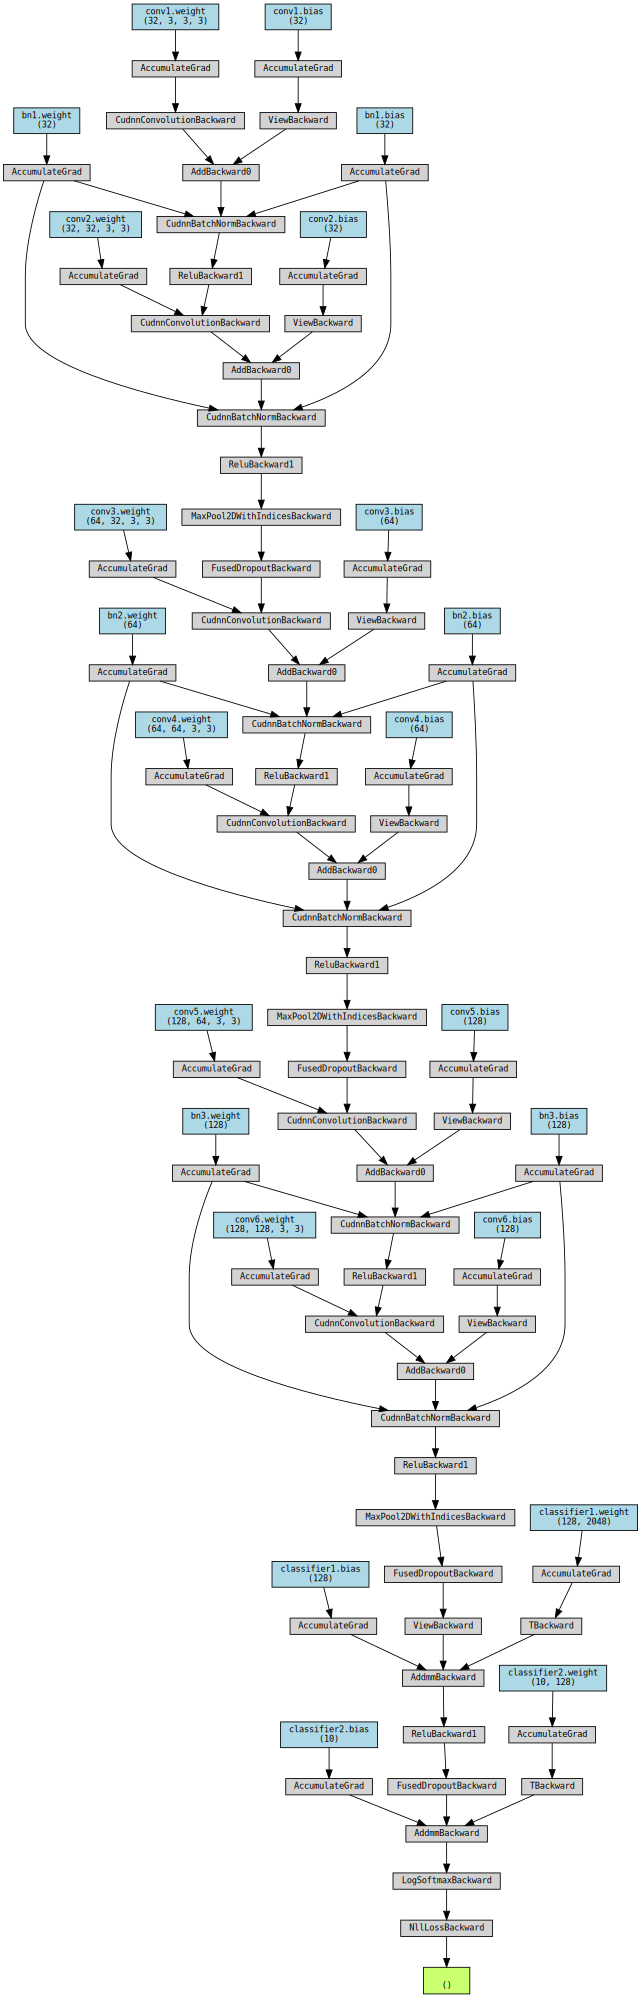

In [70]:
# 損失関数のグラフ表示
net = CNN_v5(n_output).to(device)
criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [71]:
graph_pdf(g)

pdf-10-09


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## コラム Batch Normlizationの処理内容

In [ ]:
# 入力用ダミーデータの作成

torch.manual_seed(123)
inputs = torch.randn(1, 1, 10)
print(inputs)

tensor([[[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969,  0.2093, -0.9724,
          -0.7550,  0.3239, -0.1085]]])


In [ ]:
# 入力ミニバッチデータの統計量計算

i_mean = inputs.mean()
i_var = inputs.var(unbiased=True)
i_std = inputs.std(unbiased=False)
print(i_mean, i_std, i_var)

tensor(-0.3101) tensor(0.4867) tensor(0.2632)


In [ ]:
# BN関数の定義

bn = nn.BatchNorm1d(1)
print(bn.running_mean)
print(bn.running_var)
print(bn.weight.data)
print(bn.bias.data)

tensor([0.])
tensor([1.])
tensor([1.])
tensor([0.])


In [ ]:
# BN関数の疑似呼び出し

bn.train()
print('===訓練モード1===')
outputs1 = bn(inputs)
print(outputs1.data)
print(bn.running_mean)
print(bn.running_var)

bn.eval()
print('===予測モード1===')
outputs2 = bn(inputs)
print(outputs2.data)
print(bn.running_mean)
print(bn.running_var)

bn.train()
print('===訓練モード2===')
outputs3 = bn(inputs)
print(outputs3.data)
print(bn.running_mean)
print(bn.running_var)

bn.eval()
print('===予測モード2===')
outputs4 = bn(inputs)
print(outputs4.data)
print(bn.running_mean)
print(bn.running_var)


===訓練モード1===
tensor([[[ 0.4081,  0.8844, -0.1224,  0.1431, -1.8222,  1.0671, -1.3608,
          -0.9143,  1.3027,  0.4142]]])
tensor([-0.0310])
tensor([0.9263])
===予測モード1===
tensor([[[-0.0836,  0.1573, -0.3518, -0.2176, -1.2114,  0.2496, -0.9781,
          -0.7523,  0.3688, -0.0805]]])
tensor([-0.0310])
tensor([0.9263])
===訓練モード2===
tensor([[[ 0.4081,  0.8844, -0.1224,  0.1431, -1.8222,  1.0671, -1.3608,
          -0.9143,  1.3027,  0.4142]]])
tensor([-0.0589])
tensor([0.8600])
===予測モード2===
tensor([[[-0.0567,  0.1933, -0.3351, -0.1957, -1.2271,  0.2892, -0.9850,
          -0.7507,  0.4128, -0.0535]]])
tensor([-0.0589])
tensor([0.8600])


In [ ]:
# 訓練モードの出力

xt = (inputs - i_mean)/i_std * bn.weight + bn.bias
print(xt.data)

print(outputs1.data)

tensor([[[ 0.4081,  0.8845, -0.1224,  0.1431, -1.8223,  1.0671, -1.3608,
          -0.9143,  1.3027,  0.4142]]])
tensor([[[ 0.4081,  0.8844, -0.1224,  0.1431, -1.8222,  1.0671, -1.3608,
          -0.9143,  1.3027,  0.4142]]])


In [ ]:
# 予測モードの出力

xp = (inputs-bn.running_mean)/torch.sqrt(bn.running_var)
print(xp.data)

print(outputs4.data)

tensor([[[-0.0567,  0.1933, -0.3351, -0.1957, -1.2271,  0.2892, -0.9850,
          -0.7507,  0.4128, -0.0535]]])
tensor([[[-0.0567,  0.1933, -0.3351, -0.1957, -1.2271,  0.2892, -0.9850,
          -0.7507,  0.4128, -0.0535]]])


In [ ]:
# running_meanとrunnung_varの計算式

# 初期値
mean0 = 0
var0 = 1
momentum = bn.momentum

# 移動平均計算1回目
mean1 = (1-momentum) * mean0 +  momentum * i_mean
var1 = (1-momentum) * var0 +  momentum * i_var
print(mean1, var1)

# 移動平均計算2回目
mean2 = (1-momentum) * mean1 +  momentum * i_mean
var2 = (1-momentum) * var1 +  momentum * i_var
print(mean2, var2)


tensor(-0.0310) tensor(0.9263)
tensor(-0.0589) tensor(0.8600)
